## Clean data and Interpolate
This notebook is a continuation of 'query_with_bounding_boxes.ipynb'. It takes the depth-to-surface area table that was generated in 'query_with_bounding_boxes' and fixes the depth-to-surface area relationship by interpolating/extrapolating missing or bad data points. It's better to use a new notebook for this because I didn't want to keep regenerating the depth-to-surface area tables, as it takes an hour or something. So I just saved out the csv file and now I can bring it in with Pandas to edit.  Basically, this notebook deletes surface areas that are lower than the depth before it (because surface area should increase with depth). Then when it only has good data points, it fits a curve using the Pandas interpolate() function, or else using some kind of polynomial of log function.

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#read the depth-to-surface area table with pandas
df = pd.read_csv('depth_to_surface_unlimitedImages.csv')
df = df.drop(columns = ['Unnamed: 0'])
df = df.set_index("ID")

## Split the dataframe into multiple dataframes, one for each reservoir
The dataframes can be contained individually inside a list. Eventually, this code will loop over every dataframe in the list (ie every depth-to-surface area table) but while it's being developed we can do it for just one table. Specify t as the number from the list you want to look at (I don't know which numbers are which, just pick a random number between 0 and 150 or something). It's important to check a few different random depth-to-surface area relationships because the reservoirs are all so different. 

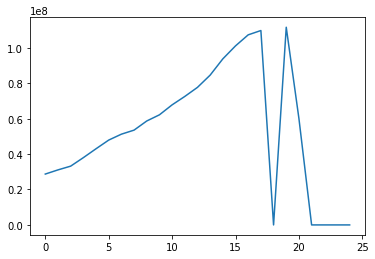

In [3]:
t = 25 # this is just to test individual reservoirs, like a random one from the list

#Split the dataframe into multiple dataframes, one for each reservoir
ID_array = np.unique(df.index)
ID_list = ID_array.tolist()

#use groupby() pandas function to group by unique values (ie by gauge ID)
data_list = []
grouped = df.groupby(df.index) 
for ID in ID_list:
    section = grouped.get_group(str(ID))
    data_list.append(section)

#Change the index to a zero base index for each reservoir (0 to n, like what it's default index would be)
data_list_reindex = []
for reservoir in data_list:
    df1 = reservoir.sort_values("Depth")
    df1 = df1.reset_index()
    data_list_reindex.append(df1)

#Have a look at the unedited surface area graph for the random reservoir you chose
test1 = data_list_reindex[t]
test1['Surface Area'].plot()

## Delete bad data for each reservoir 
Change zero values or values where the surface area decreases with depth to N/A

In [4]:
data_list2 = []
for n in data_list_reindex:
# This loop gets rid of datapoints if they show the surface area going down with depth, when it should go up
    obs_list = []

    for i, obs in n.iterrows():
        if i == 0: #We always put the first point in, even if it's bad (will fix later)
            obs_list.append(obs)
            continue
        if obs["Surface Area"] > obs_list[-1]["Surface Area"]: # if the number is bigger than the number before it, keep.
            obs_list.append(obs)

        obs_df = pd.DataFrame(obs_list)
    data_list2.append(obs_df)

test2 = data_list2[t]

## Fill in data gaps using interpolate()

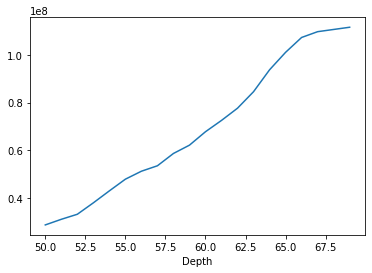

In [5]:
#Give the dataframe the original range
min_ = int(test2.index.min())
max_ = int(test2.index.max()+1)
test3 = test2.reindex(range(min_, max_))

#Interpolate
test3['Surface Area'] = test3["Surface Area"].interpolate()
test3['ID'] = test2.at[0, 'ID']
test3['Depth'] = test3.Depth.fillna(0.0).astype(int)


#Fix the 0 values in the depth index
obs_df_depth = test3.set_index("Depth")
n = len(obs_df_depth)
first = test3.at[0, 'Depth']
last = first+n
test_range = list(range(first, last))
obs_df_depth['Depth'] = test_range
obs_df_depth.index = obs_df_depth['Depth']
test4 = obs_df_depth.drop(columns = ['Depth'])

#check what the surface area graph looks like after interpolation
test4['Surface Area'].plot()

## Extrapolate the highest depths that may be missing from the real data
interpolate( ) won't work if the missing data is at the extremity. Instead it will just flat line the missing highest depths to be the same as the last depth it had. It's probably more accurate to estimate these missing higher depths using some kind of function.

In [6]:
# Make a polynomial function to fit a curve to the datapoints
x = list(test2['Depth'])
y = list(test2['Surface Area'])
length = len(y)
z = np.polyfit(x, y, 3)

f = np.poly1d(z)
n_fit = len(f)

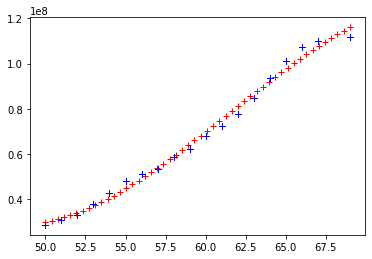

In [7]:
start = x[0]
stop = x[-1]

#See how good the curve looks when your function is applied to the incomplete data. 
#The line should always increas, as surface area should always increase with depth.
for x1 in np.linspace(start, stop):
    plt.plot(x, y, 'b+')
    plt.plot(x1, f(x1), 'r+')    
plt.axis()
plt.show()